# Multivariate linear regression: Predicting the AQI (air quality index) using weather and pollution data for Aoti Zhongxin station - Beijing.

## Introduction
This data set includes air pollutants data from Aoti Zhongxin station(Beijing) taken from the Beijing Municipal Environmental Monitoring Center. Variables in this dataset include: time, measured concentrations of various pollutants, temperature, pressure, dew point, precipitation and wind information. The time period is: March 1st, 2013 - February 28th, 2017.  
AQI is a measurement for air quality that indicates how polluted the air currently is. It is calculated using the pollution levels of O3, PM2.5, PM10, CO, SO2 and NO2.  
We will use a multivariate linear regression model to answer the question "How do the chosen weather variables affect AQI in Beijing?".

## Preliminary exploratory data analysis

In [1]:
# Load libraries, run before everything else
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("con2aqi")
library(con2aqi)
library(zoo) # for moving averages

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
# Get weather + pollution data for the Aotizhongxin station in Beijing
download.file("https://raw.githubusercontent.com/DonkeyBlaster/dsci-100-2023w1-group43/main/PRSA_Data_Aotizhongxin_20130301-20170228.csv", "Aotizhongxin_data.csv")
air_quality_data <- read_csv("Aotizhongxin_data.csv") |>
    select(-station) |> # This just says "Aotizhongxin", no need to keep it around
    select(-No)  # This is a continuously increasing counter, we don't need it either
head(air_quality_data, 3)
tail(air_quality_data, 3)

Rows: 35064 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): wd, station
dbl (16): No, year, month, day, hour, PM2.5, PM10, SO2, NO2, CO, O3, TEMP, P...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


year month day hour PM2.5 PM10 SO2 NO2 CO  O3 TEMP PRES   DEWP  RAIN wd  WSPM
1 2013 3     1   0    4     4    4    7  300 77 -0.7 1023.0 -18.8 0    NNW 4.4 
2 2013 3     1   1    8     8    4    7  300 77 -1.1 1023.2 -18.2 0    N   4.7 
3 2013 3     1   2    7     7    5   10  300 73 -1.1 1023.5 -18.2 0    NNW 5.6

year month day hour PM2.5 PM10 SO2 NO2 CO  O3 TEMP PRES   DEWP  RAIN wd  WSPM
1 2017 2     28  21   16    37   10  66  700 58 10.8 1014.2 -13.3 0    NW  1.1 
2 2017 2     28  22   21    44   12  87  700 35 10.5 1014.4 -12.9 0    NNW 1.2 
3 2017 2     28  23   19    31   10  79  600 42  8.6 1014.1 -15.9 0    NNE 1.3

AQI can be easily calculated with the "con2aqi" library (after wrangling). First, we remove any N/A values:

In [3]:
air_quality_data <- air_quality_data |> na.omit() # AQI cannot be calculated with NA values

Additionally, we need to wrangle the pollutant units into ones the library understands. Existing data are in ug/m^3, and the library wants the following units:
| PM2.5  | PM10   | SO2 | NO2 | CO  | O3  |
|--------|--------|-----|-----|-----|-----|
| ug/m^3 | ug/m^3 | ppb | ppb | ppm | ppm |

In [4]:
R = 0.082057366080960  # Gas constant for litres, atmospheres, kelvin, mols.
SO2_molecular_weight = 64.07  # g/mol
NO2_molecular_weight = 46.01  # g/mol
CO_molecular_weight = 28.01  # g/mol
O3_molecular_weight = 48.00  # g/mol
air_quality_data <- air_quality_data |>
    # PV = nRT formula rearranged to V = RT/P, n=1.
    mutate(volume = R * (273.2 + TEMP) / (PRES/1013)) |>   # Convert temp to Kelvin, pressure to atmospheres
    mutate(so2_ppb = volume * SO2 / SO2_molecular_weight) |>
    mutate(no2_ppb = volume * NO2 / NO2_molecular_weight) |>
    # Multiply by div by 1000 for ppb -> ppm
    mutate(co_ppm = volume * CO / CO_molecular_weight / 1000) |>
    mutate(o3_ppm = volume * O3 / O3_molecular_weight / 1000)
head(air_quality_data, 3)
tail(air_quality_data, 3)

year month day hour PM2.5 PM10 SO2 NO2 CO  O3 ⋯ PRES   DEWP  RAIN wd  WSPM
1 2013 3     1   0    4     4    4    7  300 77 ⋯ 1023.0 -18.8 0    NNW 4.4 
2 2013 3     1   1    8     8    4    7  300 77 ⋯ 1023.2 -18.2 0    N   4.7 
3 2013 3     1   2    7     7    5   10  300 73 ⋯ 1023.5 -18.2 0    NNW 5.6 
  volume   so2_ppb  no2_ppb  co_ppm    o3_ppm    
1 22.14205 1.382366 3.368711 0.2371516 0.03551954
2 22.10523 1.380067 3.363108 0.2367572 0.03546047
3 22.09875 1.724579 4.803032 0.2366878 0.03360852

year month day hour PM2.5 PM10 SO2 NO2 CO  O3 ⋯ PRES   DEWP  RAIN wd  WSPM
1 2017 2     28  21   16    37   10  66  700 58 ⋯ 1014.2 -13.3 0    NW  1.1 
2 2017 2     28  22   21    44   12  87  700 35 ⋯ 1014.4 -12.9 0    NNW 1.2 
3 2017 2     28  23   19    31   10  79  600 42 ⋯ 1014.1 -15.9 0    NNE 1.3 
  volume   so2_ppb  no2_ppb  co_ppm    o3_ppm    
1 23.27672 3.633014 33.38977 0.5817102 0.02812603
2 23.24755 4.354152 43.95863 0.5809812 0.01695134
3 23.09868 3.605226 39.66086 0.4947951 0.02021135

Next, we need to calculate moving averages for the concentrations, as per [the specification](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf). Each pollutant has a different period required, shown below:
| PM2.5    | PM10     | SO2      | NO2    | CO      | O3           |
|----------|----------|----------|--------|---------|--------------|
| 24 hours | 24 hours | 1 hour   | 1 hour | 8 hours | 1 or 8 hours |


In [5]:
air_quality_data <- air_quality_data |>
    mutate(pm2.5_24hour = zoo::rollmean(PM2.5, k = 24, fill = NA, align = "right")) |>
    mutate(pm10_24hour = zoo::rollmean(PM10, k = 24, fill = NA, align = "right")) |>
    mutate(co_8hour = zoo::rollmean(co_ppm, k = 8, fill = NA, align = "right")) |>
    mutate(o3_8hour = zoo::rollmean(o3_ppm, k = 8, fill = NA, align = "right"))  # For o3 specifically, con2aqi allows us to choose 1 or 8 hours.
    # We're using 8 hours as the 1-hour window does not allow for reporting of AQI values less than 101.
head(air_quality_data, 26)

year month day hour PM2.5 PM10 SO2 NO2 CO  O3 ⋯ WSPM volume   so2_ppb 
1  2013 3     1    0    4     4    4   7  300 77 ⋯ 4.4  22.14205 1.382366
2  2013 3     1    1    8     8    4   7  300 77 ⋯ 4.7  22.10523 1.380067
3  2013 3     1    2    7     7    5  10  300 73 ⋯ 5.6  22.09875 1.724579
4  2013 3     1    3    6     6   11  11  300 72 ⋯ 3.1  22.05284 3.786191
5  2013 3     1    4    3     3   12  12  300 72 ⋯ 2.0  21.98913 4.118458
6  2013 3     1    5    5     5   18  18  400 66 ⋯ 3.7  21.96435 6.170723
7  2013 3     1    6    3     3   18  32  500 50 ⋯ 2.5  21.91270 6.156213
8  2013 3     1    7    3     6   19  41  500 43 ⋯ 3.8  21.97441 6.516526
9  2013 3     1    8    3     6   16  43  500 45 ⋯ 4.1  22.09260 5.517115
10 2013 3     1    9    3     8   12  28  400 59 ⋯ 2.6  22.17721 4.153683
11 2013 3     1   10    3     6    9  12  400 72 ⋯ 3.6  22.24027 3.124121
12 2013 3     1   11    3     6    9  14  400 71 ⋯ 3.7  22.32111 3.135477
13 2013 3     1   12    3     6    7  13  300 74 ⋯ 5.1  22.42158 2.449681
14 2013 3     1   13    3     6    7  12  400 76 ⋯ 4.3  22.55902 2.464697
15 2013 3     1   14    6     9    7  11  400 77 ⋯ 4.4  22.62233 2.471614
16 2013 3     1   15    8    15    7  14  400 76 ⋯ 2.8  22.64295 2.473867
17 2013 3     1   16    9    19    9  13  400 76 ⋯ 3.9  22.62085 3.177581
18 2013 3     1   17   10    23   11  15  400 74 ⋯ 2.8  22.47583 3.858812
19 2013 3     1   18   11    20    8  20  500 70 ⋯ 2.1  22.35467 2.791281
20 2013 3     1   19    8    14   12  30  500 60 ⋯ 2.8  22.27044 4.171145
21 2013 3     1   20   11    17   13  33  600 55 ⋯ 2.1  22.20466 4.505394
22 2013 3     1   21   12    18   16  35  500 50 ⋯ 0.8  22.09434 5.517551
23 2013 3     1   22   15    19   21  57  700 32 ⋯ 1.8  22.10997 7.246906
24 2013 3     1   23   24    24   26  54  600 36 ⋯ 1.4  22.02123 8.936353
25 2013 3     2    0   22    24   24  44  500 44 ⋯ 1.4  21.99443 8.238900
26 2013 3     2    1   14    17   21  36  400 50 ⋯ 1.1  21.93967 7.191089
   no2_ppb   co_ppm    o3_ppm     pm2.5_24hour pm10_24hour co_8hour  o3_8hour  
1   3.368711 0.2371516 0.03551954    NA              NA           NA         NA
2   3.363108 0.2367572 0.03546047    NA              NA           NA         NA
3   4.803032 0.2366878 0.03360852    NA              NA           NA         NA
4   5.272359 0.2361961 0.03307926    NA              NA           NA         NA
5   5.735049 0.2355137 0.03298370    NA              NA           NA         NA
6   8.592876 0.3136644 0.03020098    NA              NA           NA         NA
7  15.240303 0.3911585 0.02282573    NA              NA           NA         NA
8  19.581630 0.3922601 0.01968541    NA              NA    0.2849237 0.03042045
9  20.647289 0.3943699 0.02071181    NA              NA    0.3045759 0.02856948
10 13.496235 0.3167041 0.02725948    NA              NA    0.3145693 0.02754436
11  5.800548 0.3176047 0.03336040    NA              NA    0.3246839 0.02751335
12  6.791905 0.3187592 0.03301664    NA              NA    0.3350043 0.02750552
13  6.335157 0.2401455 0.03456661    NA              NA    0.3355833 0.02770338
14  5.883682 0.3221566 0.03571845    NA              NA    0.3366448 0.02839307
15  5.408513 0.3230608 0.03628999    NA              NA    0.3281326 0.03007610
16  6.889836 0.3233553 0.03585134    NA              NA    0.3195195 0.03209684
17  6.391458 0.3230396 0.03581634    NA              NA    0.3106032 0.03398491
18  7.327481 0.3209686 0.03465023    NA              NA    0.3111363 0.03490875
19  9.717311 0.3990481 0.03260057    NA              NA    0.3213167 0.03481377
20 14.521043 0.3975444 0.02783805    NA              NA    0.3311649 0.03416645
21 15.925970 0.4756443 0.02544284    NA              NA    0.3606022 0.03302598
22 16.807259 0.3944010 0.02301494    NA              NA    0.3696328 0.03143804
23 27.391176 0.5525518 0.01473998    NA              NA    0.3983191 0.02874429
24 25.845396 0.4717151 0.01651593 7.125        10.75000    0.4168641 0.02632736
25 21

Finally, we calculate AQI for each pollutant.

In [6]:
# This cell takes a while.
air_quality_data <- air_quality_data |>
    na.omit() |>  #  We will remove all rows with NA first.
    mutate(pm2.5_aqi = con2aqi(pollutant = "pm25", con = pm2.5_24hour)) |>
    mutate(pm10_aqi = con2aqi(pollutant = "pm10", con = pm10_24hour)) |>
    mutate(so2_aqi = con2aqi(pollutant = "so2", con = so2_ppb)) |>
    mutate(no2_aqi = con2aqi(pollutant = "no2", con = no2_ppb)) |>
    mutate(co_aqi = con2aqi(pollutant = "co", con = co_8hour)) |>
    mutate(o3_aqi = con2aqi(pollutant = "o3", con = o3_8hour, type = "8h"))
air_quality_data
    

year month day hour PM2.5 PM10 SO2 NO2 CO   O3  ⋯ pm2.5_24hour
1     2013 3     1   23    24    24  26   54  600 36  ⋯  7.125000   
2     2013 3     2    0    22    24  24   44  500 44  ⋯  7.875000   
3     2013 3     2    1    14    17  21   36  400 50  ⋯  8.125000   
4     2013 3     2    2    13    13  20   37  400 47  ⋯  8.375000   
5     2013 3     2    3     3     9  13   34  400 52  ⋯  8.250000   
6     2013 3     2    4     3     7  18   43  400 43  ⋯  8.250000   
7     2013 3     2    5     9    11  19   70  500 20  ⋯  8.416667   
8     2013 3     2    6     4    10  28   46  500 39  ⋯  8.458333   
9     2013 3     2    7     3    11  34   58  500 27  ⋯  8.458333   
10    2013 3     2    8     3     7  21   49  500 43  ⋯  8.458333   
11    2013 3     2    9    10    14  47   62  700 29  ⋯  8.750000   
12    2013 3     2   10    11    19  36   60  600 34  ⋯  9.083333   
13    2013 3     2   11    18    29  36   70  800 27  ⋯  9.708333   
14    2013 3     2   12    26    30  25   76  900 22  ⋯ 10.666667   
15    2013 3     2   13    25    33  20   57  700 39  ⋯ 11.583333   
16    2013 3     2   14    26    35  22   54  700 43  ⋯ 12.416667   
17    2013 3     2   15    37    40  24   55  700 44  ⋯ 13.625000   
18    2013 3     2   16    37    46  29   63 1000 38  ⋯ 14.791667   
19    2013 3     2   17    44    58  45   77 1200 30  ⋯ 16.208333   
20    2013 3     2   18    54    79  50   80 1100 24  ⋯ 18.000000   
21    2013 3     2   19    61    86  50   97 1300 10  ⋯ 20.208333   
22    2013 3     2   20    67    96  54  108 1399  2  ⋯ 22.541667   
23    2013 3     2   21    74   103  72  107 1399  2  ⋯ 25.125000   
24    2013 3     2   22    81   113  84  110 1500  3  ⋯ 27.875000   
25    2013 3     2   23    93   120  87  107 1700  2  ⋯ 30.750000   
26    2013 3     3    0   112   130  73  100 1899  2  ⋯ 34.500000   
27    2013 3     3    1   109   132  80  101 2200  2  ⋯ 38.458333   
28    2013 3     3    2   110   132  98   99 2399  2  ⋯ 42.500000   
29    2013 3     3    3   105   129  88  100 2500  2  ⋯ 46.750000   
30    2013 3     3    4   106   136  79   92 2799  2  ⋯ 51.041667   
⋮     ⋮    ⋮     ⋮   ⋮    ⋮     ⋮    ⋮   ⋮   ⋮    ⋮   ⋱ ⋮           
31763 2017 2     27  18   47     60   9   53  700 106 ⋯ 61.16667    
31764 2017 2     27  19   51     77  10   90  100  62 ⋯ 62.20833    
31765 2017 2     27  20   51     77   9  116 1100  35 ⋯ 63.12500    
31766 2017 2     27  21   53     82   9  124 1200  24 ⋯ 64.08333    
31767 2017 2     27  22   58    106  17  133 1500  19 ⋯ 65.25000    
31768 2017 2     27  23   70    107  28  131 1700  19 ⋯ 66.66667    
31769 2017 2     28   0   56     56  22  119 1400  18 ⋯ 67.25000    
31770 2017 2     28   1   15     15   7   45  500  71 ⋯ 65.75000    
31771 2017 2     28   2    9     16   7   33  400  82 ⋯ 64.20833    
31772 2017 2     28   3    7     15   8   42  300  70 ⋯ 62.91667    
31773 2017 2     28   4   13     21  14   45  500  66 ⋯ 61.16667    
31774 2017 2     28   5   12     22  16   29  400  77 ⋯ 58.45833    
31775 2017 2     28   6    9     16  17   34  500  73 ⋯ 55.29167    
31776 2017 2     28   7   11     24  15   47  500  61 ⋯ 51.83333    
31777 2017 2     28   8   13     33  16   52  500  58 ⋯ 48.37500    
31778 2017 2     28   9   12     24  13   46  500  69 ⋯ 45.54167    
31779 2017 2     28  10   11     16   6   24  300  93 ⋯ 42.95833    
31780 2017 2     28  11    7      8   4   12  200 107 ⋯ 40.70833    
31781 2017 2     28  12    6     13   3   10  200 112 ⋯ 38.79167    
31782 2017 2     28  13    6      8   3    9  100 115 ⋯ 35.33333    
31783 2017 2     28  14    5      5   4    8  100 117 ⋯ 31.25000    
31784 2017 2     28  15    6     19   4    8  100 122 ⋯ 27.54167    
31785 2017 2     28  16   12     18   5    9  200 122 ⋯ 24.91667    
31786 2017 2     28  17   12     23   6   13  200 120 ⋯ 23.00000    
31787 2017 2     28  18   13     29   5   22  300 109 ⋯ 21.58333    
31788 2017 2     28  19   12     29   5   35  400  95 ⋯ 19.95833    
3178

Because AQI is reported daily as the highest of the individual pollutant AQIs, we can obtain one final AQI value per day.

In [7]:
air_quality_data <- air_quality_data |>
    select(year, month, day, hour, TEMP, PRES, DEWP, RAIN, WSPM, pm2.5_aqi, pm10_aqi, so2_aqi, no2_aqi, co_aqi, o3_aqi) |>
    group_by(year, month, day) |>
    summarize(across(TEMP:WSPM, mean), across(pm2.5_aqi:o3_aqi, max)) |>
    rowwise()|>
    mutate(aqi = round(max(pm2.5_aqi:o3_aqi)))
head(air_quality_data, 3)
tail(air_quality_data, 3)
    

`summarise()` has grouped output by 'year', 'month'. You can override using the
`.groups` argument.


year month day TEMP       PRES     DEWP      RAIN WSPM     pm2.5_aqi pm10_aqi
1 2013 3     1   -0.2000000 1030.500 -17.40000 0    1.400000  30       10      
2 2013 3     2    0.6166667 1026.850 -15.93750 0    1.479167  91       39      
3 2013 3     3    5.5666667 1014.608 -12.31667 0    1.658333 166       85      
  so2_aqi no2_aqi co_aqi o3_aqi aqi
1 13      25       5     25      30
2 44      50      12     23      91
3 66      67      22     24     166

year month day TEMP      PRES     DEWP       RAIN WSPM     pm2.5_aqi pm10_aqi
1 2017 2     26   7.208333 1020.337  -8.258333 0    1.566667  85       38      
2 2017 2     27   7.809524 1017.143  -7.395238 0    1.523810 157       69      
3 2017 2     28  10.958333 1014.888 -12.783333 0    2.058333 158       69      
  so2_aqi no2_aqi co_aqi o3_aqi aqi
1 10      48      10     39      85
2 21      66      17     36     157
3 12      58      11     57     158

We can visualize this data to gain some insight into how certain predictor variables may be affecting overall AQI.

`summarise()` has grouped output by 'year', 'month'. You can override using the
`.groups` argument.


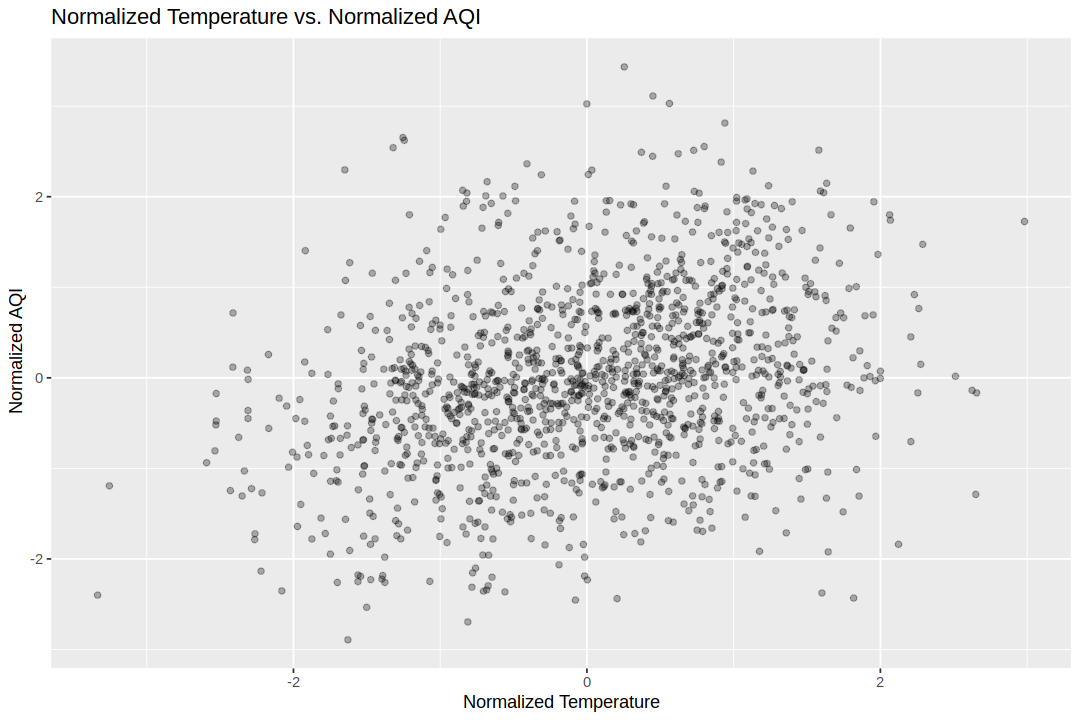

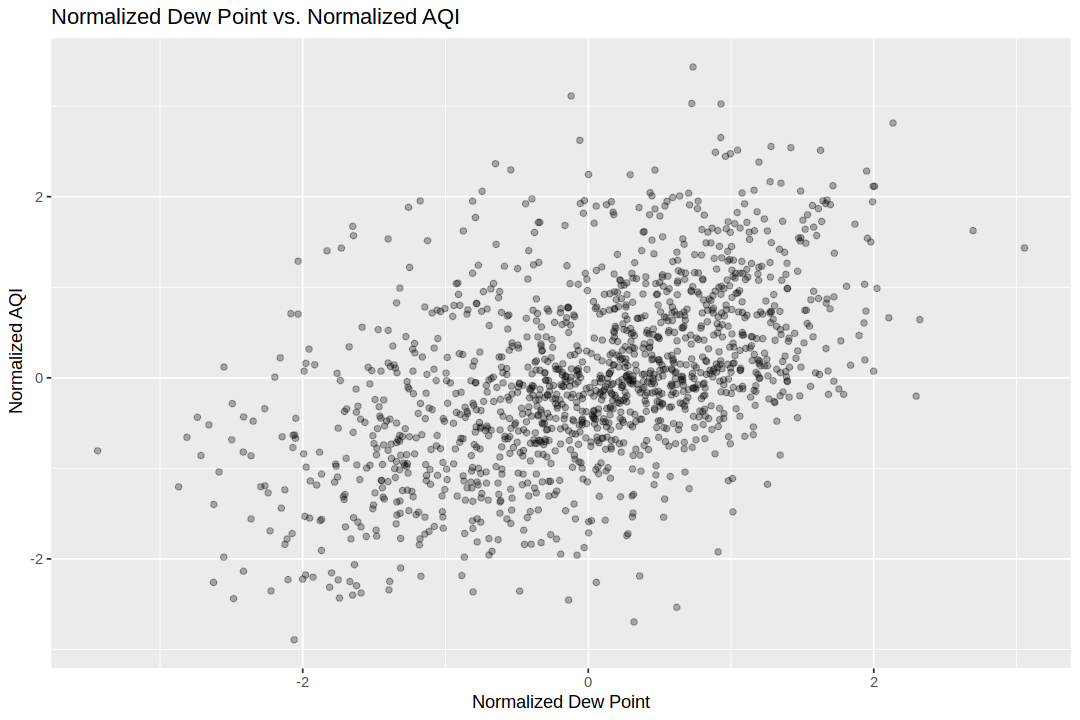

Warning message:
“Removed 165 rows containing missing values (`geom_point()`).”


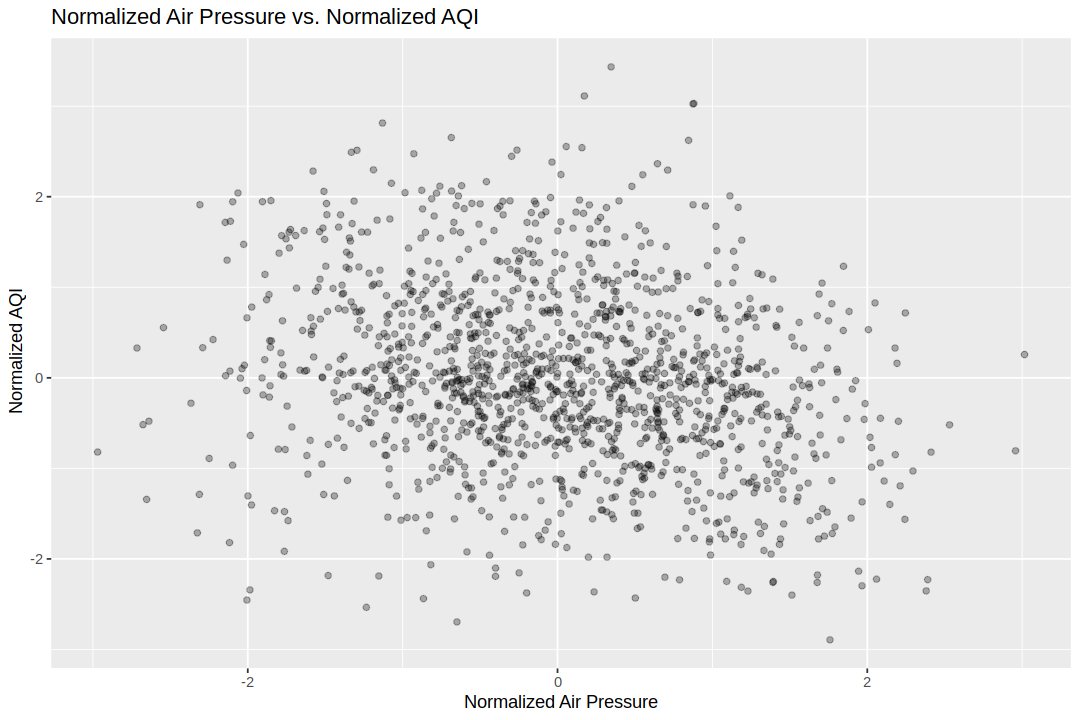

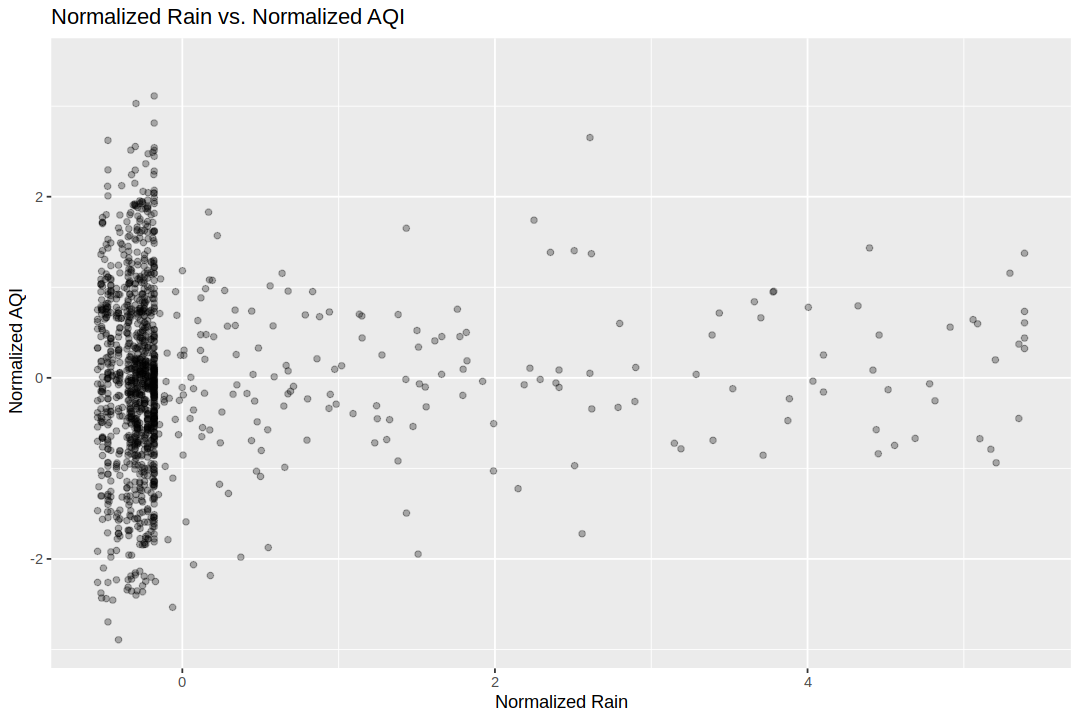

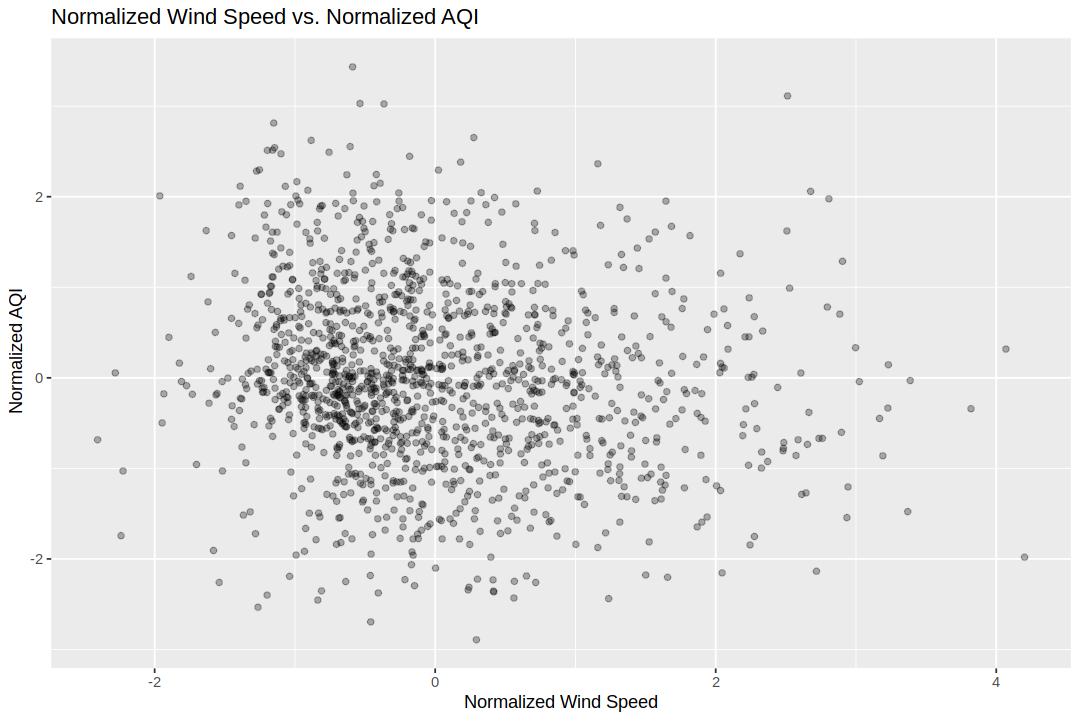

In [8]:
options(repr.plot.width = 9, repr.plot.height = 6)
scaled_data <- air_quality_data |>
    group_by(year, month, day) |>
    summarize(across(TEMP:aqi, mean)) |>
    mutate(across(TEMP:aqi, scale))  # Normalize values to make them easier to compare

ggplot(scaled_data, aes(x = TEMP, y = aqi)) +
    geom_point(alpha = 0.3) +
    labs(x = "Normalized Temperature", y = " Normalized AQI", title = "Normalized Temperature vs. Normalized AQI")
ggplot(scaled_data, aes(x = DEWP, y = aqi)) +
    geom_point(alpha = 0.3) +
    labs(x = "Normalized Dew Point", y = " Normalized AQI", title = "Normalized Dew Point vs. Normalized AQI")
ggplot(scaled_data, aes(x = PRES, y = aqi)) +
    geom_point(alpha = 0.3) +
    labs(x = "Normalized Air Pressure", y = " Normalized AQI", title = "Normalized Air Pressure vs. Normalized AQI")
ggplot(scaled_data, aes(x = RAIN, y = aqi)) +
    geom_point(alpha = 0.3) +
    labs(x = "Normalized Rain", y = " Normalized AQI", title = "Normalized Rain vs. Normalized AQI")
ggplot(scaled_data, aes(x = WSPM, y = aqi)) +
    geom_point(alpha = 0.3) +
    labs(x = "Normalized Wind Speed", y = " Normalized AQI", title = "Normalized Wind Speed vs. Normalized AQI")

The relationships in these graphs indicate which variables may be most useful in our model.

## Method
We will carry out a multivariate linear regression analysis on our data, to predict AQI based on weather conditions. We chose this method because:
* Knn would be very slow for such a large dataset
* We can have more confidence in our model for predictions where weather conditions are slightly beyond the range of inputs (more extreme weather)
* The regression equation shows a mathematical relationship – quantifies the relative contribution of each predictor    

Before creating our model, we will consider each variable, and their relationships, as follows:
* Wind direction is given in the dataset, but disregarded as it is not numerical 
* The dataset is large - any outliers are not likely to strongly affect our results
* We will assess the relationships between our weather variables (by producing pairwise scatter plots), to identify correlations between them and avoid multicollinearity.



## Expected Outcomes and Significance

- Compared to **AQI**, based on our research, we expect:
    - Positive correlations with:
        - **Pressure** - higher pressures will stagnate air, causing pollutants to accumulate
    - Negative correlations with:
        - **Wind speed** - faster winds disperse pollutants, lowering concentrations
        - **Temperature** - higher ground temperature causes hot air to rise, reducing atmospheric pressure
        - **Precipitation** - this traps pollutants as they descend
        - **Dew point** - higher dew points form more water droplets, which traps pollutants
- Impacts:
    - Bad air quality contributes to thousands of hospital visits and premature deaths a year, with the related consequences totaling to an economic value of $120bn dollars a year. Thus, these findings could allow individuals to take preventative measures against pollution to protect their health.
- Future research:
  - We could use location-based predictors such as wind direction and topography to ask the question “How is AQI affected by location?”.
  - Additionally, we could ask “How is AQI affected by transportation and energy?” to investigate whether lifestyle contributes to pollution.


Word count: 517

### References

“Air pollution – How to convert between mg/m3, µg/m3 and ppm, ppb.” Breeze Technologies, 20 Aug.
2021,https://www.breeze-technologies.de/blog/air-pollution-how-to-convert-between-mgm3-%C2%B5gm3-ppm-ppb/. 
Accessed 28 Oct. 2023.


Feng, Xinyuan and Shigong Wang, “Influence of different weather events on concentrations of 
particulate matter with different sizes in Lanzhou, China.”Journal of Environmental
Sciences, Vol. 24, no. 4, 2012, pp. 665-674. https://doi.org/10.1016/S1001-0742(11)60807-3.


“Health impacts from air pollution.” Government of Canada, 2 June 2023, https://www.canada.ca/en/environment-climate-change/campaigns/canadian-environment-week/clean-air-day/health-impacts-air-pollution.html.  Accessed 28 Oct. 2023.


“How the weather affects air quality.” Government of Canada, 26 Jan. 2023,
https://www.canada.ca/en/environment-climate-change/services/air-quality-health-index/weather.html. 
Accessed 28 Oct. 2023.


Kumari, Shweta, and Manish Kumar Jane. (2018). “A Critical Review on Air Quality Index.” Water 
Science and Technology Library, vol. 77. Springer, Singapore. https://doi.org/10.1007/978-981-10-5792-2_8.


Liu, Yansui, Yang Zhou, and Jiaxin Lu. “Exploring the relationship between air pollution and
meteorological conditions in China under environmental governance.” Scientific Reports, vol.
10, no. 1, 2020, pp. 1-14. https://www.nature.com/articles/s41598-020-71338-7.
doi: 10.1038/s41598-020-71338-7.


Technical Assistance Document for the Reporting of Daily Air Quality – the Air Quality Index
(AQI). USEPA, 2018. https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf.


Xu, Yingying and Xinyue Zhu, "Recognizing Dew as an Indicator and an Improver of Near-Surface Air
Quality", Advances in Meteorology, vol. 2017, 2017. https://doi.org/10.1155/2017/3514743.

